In [1]:
from train import train_model
from utils import load_config, load_model, inference
from utils import visualize_output, get_keypoints_from_heatmaps
import cv2
import numpy as np
from dataset import PoseDataset
import torch

In [3]:
config = load_config('./config_w48_384x288.yaml')
config['model']['weights'] = 'runs/20240918_205337/checkpoint_epoch_5/weights_epoch_5.pth'

In [4]:
dataset = PoseDataset(config["dataset"], config["dataset"]['val'])
# get one sample from the dataset
# image,target,keypoints_gt,keypoint_visibility = dataset[334]
# image,target,keypoints_gt,keypoint_visibility = dataset[632]
image,target,keypoints_gt,keypoint_visibility = dataset[191]

In [4]:
# image = cv2.imread("./example_images/demo_cropped.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (384, 288))
# image = image.transpose(2, 0, 1)
# image = image.astype(np.float32)
# image /= 255.0

# image = torch.tensor(image)

In [11]:
result = inference(config, image.unsqueeze(0))

keypoints = get_keypoints_from_heatmaps(result, (image.shape[1], image.shape[2]))

In [12]:
config = load_config('./config_w48_384x288.yaml')
result = inference(config, image.unsqueeze(0))

keypoints_org = get_keypoints_from_heatmaps(result, (image.shape[1], image.shape[2]))
print(image.shape)

torch.Size([3, 384, 288])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


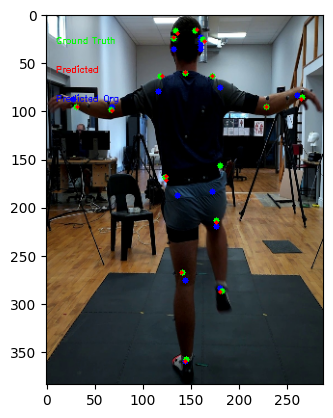

In [13]:
import matplotlib.pyplot as plt

image_show = image.permute(1,2,0).numpy()
# image_show = cv2.cvtColor(image_show, cv2.COLOR_RGB2BGR)


for i in range(keypoints_org.shape[1]):
    cv2.circle(image_show, (int(keypoints_org[0][i][0]), int(keypoints_org[0][i][1])), 3, (0,0,255), -1)

for i in range(len(keypoints_gt)):
    cv2.circle(image_show, (int(keypoints_gt[i][0]), int(keypoints_gt[i][1])), 3, (0,255,0), -1)

for i in range(keypoints.shape[1]):
    cv2.circle(image_show, (int(keypoints[0][i][0]), int(keypoints[0][i][1])), 2, (255,0,0), -1)

# add labels
cv2.putText(image_show, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
cv2.putText(image_show, 'Predicted', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
cv2.putText(image_show, 'Predicted Org', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)

# show image in notebook cell with matplotlib
plt.imshow(image_show)
plt.show()

In [3]:
import pandas as pd
df = pd.read_csv('./data/cropped.csv')

widths = df['box_w']
heights = df['box_h']

print(widths.mean(), heights.mean())
print(min(widths), max(widths))
print(min(heights), max(heights))

548.8110529171187 1101.1962069109422
56.96 1143.93
142.59 1751.4


In [2]:
image = cv2.imread("./data/cropped/cropped_C1S1A1D1_0818.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# size = (576, 768)
# size = (288, 384)
size = (192, 256)
image = cv2.resize(image, size)

# config = load_config('./config_w48_384x288.yaml')
# config = load_config('./config_ViT_B_simple.yaml')
config = load_config('./config_ViT_B_classic.yaml')

image = torch.tensor(image).float()
image /= 255.0
image = image.permute(2,0,1)
image = image.unsqueeze(0)

result = inference(config, image)

keypoints = get_keypoints_from_heatmaps(result, (image.shape[2], image.shape[3]))

/root/research-project-2024/utils.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(config["weights"])


Missing keys:  ['backbone.cls_token']


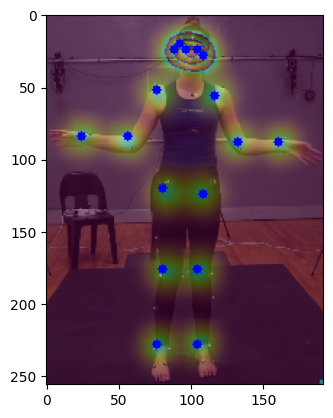

In [3]:
import matplotlib.pyplot as plt


heatmaps = result[0].cpu().detach().numpy()

image_show = cv2.imread("./data/cropped/cropped_C1S1A1D1_0818.jpg")
image_show = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB)
image_show = cv2.resize(image_show, size)

heatmap = np.sum(heatmaps, axis=0)
heatmap = cv2.resize(heatmap, size)
# heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap *= 255
heatmap = heatmap.astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
image_show = cv2.addWeighted(heatmap, 0.5, image_show, 0.5, 0)

for i in range(keypoints.shape[1]):
    cv2.circle(image_show, (int(keypoints[0][i][0]), int(keypoints[0][i][1])), 3, (0,0,255), -1)


plt.imshow(image_show)
plt.show()